In [1]:
import pandas as pd 
import numpy as np 
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_x = pd.read_csv('data/train.csv')
train_x = train_x.fillna(0)

In [3]:
train_y = train_x.iloc[:,-1]
train_x = train_x.iloc[:,1:-1]

In [4]:
train_x.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,0.0,0.000000,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,0.0,0.000000,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,0.0,0.000000,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,0.0,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,0.0,0.000000,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [5]:
train_y.head()

0    6.476038e+05
1    3.321452e+06
2    9.570885e+06
3    1.421501e+07
4    7.627120e+05
Name: total_price, dtype: float64

In [6]:
train_x['building_area'].values

array([3.41817534, 4.0413088 , 5.58427885, ..., 8.22364401, 8.728287  ,
       5.35678781])

In [7]:
train_y = train_y/train_x['building_area'].values
print(train_y)

0        1.894589e+05
1        8.218753e+05
2        1.713898e+06
3        1.048070e+06
4        1.626908e+05
5        1.094225e+05
6        1.101481e+06
7        2.104869e+05
8        2.442331e+05
9        1.579535e+06
10       6.140738e+05
11       6.265054e+05
12       6.027707e+05
13       1.254820e+06
14       1.109411e+06
15       4.655162e+05
16       9.436165e+05
17       5.193310e+05
18       1.167744e+06
19       1.001122e+06
20       1.289406e+06
21       1.329530e+06
22       5.370334e+05
23       6.741568e+05
24       4.971438e+05
25       1.002180e+06
26       3.221249e+06
27       3.018493e+05
28       2.583564e+05
29       1.179494e+06
             ...     
59970    2.369766e+05
59971    1.739598e+05
59972    4.320583e+05
59973    1.129905e+06
59974    2.647664e+06
59975    2.042754e+05
59976    1.169281e+06
59977    1.110130e+06
59978    4.430418e+05
59979    5.524989e+05
59980    1.029810e+06
59981    1.157624e+06
59982    7.563599e+05
59983    1.056995e+06
59984    1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [9]:
entity_features_columns = ['building_material','city','town','village','building_type','building_use','parking_way']
def score(y,yhat):
    z = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present > 0.1):
            z += 1
    print((1-total/len(y)))
    return z,z/len(y)*10000 + (1-total/len(y))
def custom_loss(y_true, y_pred):
    z , point = score(y_true,y_pred)
    return 'custom_loss',z, False
"""
def custom_loss(y_true, y_pred):
    loss = np.sum(np.abs(y_true-y_pred)/y_true)
    return 'custom_loss',loss, False
"""
def train_LGBM(train, t_target, valid, v_target):
      
    rf = LGBMRegressor(learning_rate=0.01, objective='regression', n_estimators=100000,
                       max_depth=16, num_leaves=256,
                       feature_fraction=0.9, bagging_freq=1,metric='rmse')

    rf.fit(train, t_target, # should we drop the features that are not correlate to our target?
           eval_set=[(train, t_target), (valid, v_target)],
           early_stopping_rounds=100, verbose=10,
           eval_metric='l1',
           categorical_feature=entity_features_columns
           )
    print("Finished.")
    return rf

In [10]:
model = train_LGBM(X_train, y_train, X_test, y_test)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['building_material', 'building_type', 'building_use', 'city', 'parking_way', 'town', 'village']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[10]	training's l1: 817279	valid_1's l1: 803673
[20]	training's l1: 747443	valid_1's l1: 735816
[30]	training's l1: 684864	valid_1's l1: 675323
[40]	training's l1: 628553	valid_1's l1: 620889
[50]	training's l1: 578097	valid_1's l1: 572376
[60]	training's l1: 532470	valid_1's l1: 528220
[70]	training's l1: 491670	valid_1's l1: 488809
[80]	training's l1: 455096	valid_1's l1: 453512
[90]	training's l1: 422154	valid_1's l1: 422023
[100]	training's l1: 392637	valid_1's l1: 394067
[110]	training's l1: 366083	valid_1's l1: 369146
[120]	training's l1: 341718	valid_1's l1: 346463
[130]	training's l1: 320240	valid_1's l1: 326438
[140]	training's l1: 301177	valid_1's l1: 308509
[150]	training's l1: 284253	valid_1's l1: 293200
[160]	training's l1: 269115	valid_1's l1: 280148
[170]	training's l1: 255705	valid_1's l1: 268617
[180]	training's l1: 243744	valid_1's l1: 258185
[190]	training's l1: 233068	valid_1's l1: 248907
[200]	training'

[1670]	training's l1: 102827	valid_1's l1: 168250
[1680]	training's l1: 102656	valid_1's l1: 168215
[1690]	training's l1: 102458	valid_1's l1: 168136
[1700]	training's l1: 102308	valid_1's l1: 168098
[1710]	training's l1: 102143	valid_1's l1: 168042
[1720]	training's l1: 101969	valid_1's l1: 168003
[1730]	training's l1: 101791	valid_1's l1: 167959
[1740]	training's l1: 101581	valid_1's l1: 167862
[1750]	training's l1: 101414	valid_1's l1: 167868
[1760]	training's l1: 101206	valid_1's l1: 167801
[1770]	training's l1: 101013	valid_1's l1: 167753
[1780]	training's l1: 100832	valid_1's l1: 167773
[1790]	training's l1: 100636	valid_1's l1: 167760
[1800]	training's l1: 100475	valid_1's l1: 167649
[1810]	training's l1: 100278	valid_1's l1: 167636
[1820]	training's l1: 100096	valid_1's l1: 167577
[1830]	training's l1: 99956.4	valid_1's l1: 167581
[1840]	training's l1: 99733.1	valid_1's l1: 167487
[1850]	training's l1: 99613.4	valid_1's l1: 167492
[1860]	training's l1: 99488.6	valid_1's l1: 167

[3300]	training's l1: 81348.2	valid_1's l1: 164106
[3310]	training's l1: 81258.2	valid_1's l1: 164108
[3320]	training's l1: 81190.2	valid_1's l1: 164083
[3330]	training's l1: 81124.1	valid_1's l1: 164099
[3340]	training's l1: 80994.8	valid_1's l1: 164065
[3350]	training's l1: 80882.6	valid_1's l1: 164041
[3360]	training's l1: 80799.2	valid_1's l1: 164020
[3370]	training's l1: 80729.9	valid_1's l1: 164036
[3380]	training's l1: 80641.4	valid_1's l1: 164047
[3390]	training's l1: 80551.6	valid_1's l1: 164025
[3400]	training's l1: 80467.2	valid_1's l1: 164010
[3410]	training's l1: 80344.9	valid_1's l1: 163984
[3420]	training's l1: 80207.9	valid_1's l1: 163954
[3430]	training's l1: 80102.9	valid_1's l1: 163939
[3440]	training's l1: 79988.5	valid_1's l1: 163928
[3450]	training's l1: 79881	valid_1's l1: 163892
[3460]	training's l1: 79776.3	valid_1's l1: 163847
[3470]	training's l1: 79676.1	valid_1's l1: 163820
[3480]	training's l1: 79552.7	valid_1's l1: 163787
[3490]	training's l1: 79436.7	val

[4920]	training's l1: 65994.7	valid_1's l1: 161323
[4930]	training's l1: 65941	valid_1's l1: 161294
[4940]	training's l1: 65872.7	valid_1's l1: 161264
[4950]	training's l1: 65776.6	valid_1's l1: 161240
[4960]	training's l1: 65722.2	valid_1's l1: 161230
[4970]	training's l1: 65616.7	valid_1's l1: 161205
[4980]	training's l1: 65543.7	valid_1's l1: 161196
[4990]	training's l1: 65441	valid_1's l1: 161191
[5000]	training's l1: 65365.6	valid_1's l1: 161174
[5010]	training's l1: 65277.8	valid_1's l1: 161167
[5020]	training's l1: 65207.4	valid_1's l1: 161172
[5030]	training's l1: 65121.6	valid_1's l1: 161148
[5040]	training's l1: 65046.2	valid_1's l1: 161145
[5050]	training's l1: 64969.8	valid_1's l1: 161150
[5060]	training's l1: 64922.3	valid_1's l1: 161159
[5070]	training's l1: 64848.7	valid_1's l1: 161148
[5080]	training's l1: 64786.1	valid_1's l1: 161119
[5090]	training's l1: 64738.5	valid_1's l1: 161123
[5100]	training's l1: 64680.4	valid_1's l1: 161118
[5110]	training's l1: 64624.3	valid

[6540]	training's l1: 55242.5	valid_1's l1: 159762
[6550]	training's l1: 55170.2	valid_1's l1: 159739
[6560]	training's l1: 55098.4	valid_1's l1: 159701
[6570]	training's l1: 55061.7	valid_1's l1: 159703
[6580]	training's l1: 55001.2	valid_1's l1: 159711
[6590]	training's l1: 54941	valid_1's l1: 159701
[6600]	training's l1: 54874.8	valid_1's l1: 159693
[6610]	training's l1: 54814.3	valid_1's l1: 159673
[6620]	training's l1: 54734.4	valid_1's l1: 159674
[6630]	training's l1: 54665.9	valid_1's l1: 159652
[6640]	training's l1: 54571.4	valid_1's l1: 159638
[6650]	training's l1: 54507.8	valid_1's l1: 159639
[6660]	training's l1: 54439.5	valid_1's l1: 159616
[6670]	training's l1: 54406.4	valid_1's l1: 159638
[6680]	training's l1: 54351	valid_1's l1: 159636
[6690]	training's l1: 54297.9	valid_1's l1: 159626
[6700]	training's l1: 54261.3	valid_1's l1: 159632
[6710]	training's l1: 54204.1	valid_1's l1: 159617
[6720]	training's l1: 54153.9	valid_1's l1: 159624
[6730]	training's l1: 54124.5	valid

[8160]	training's l1: 45539.2	valid_1's l1: 158493
[8170]	training's l1: 45477.4	valid_1's l1: 158481
[8180]	training's l1: 45420.3	valid_1's l1: 158468
[8190]	training's l1: 45357.5	valid_1's l1: 158459
[8200]	training's l1: 45308.2	valid_1's l1: 158456
[8210]	training's l1: 45269	valid_1's l1: 158446
[8220]	training's l1: 45196.5	valid_1's l1: 158432
[8230]	training's l1: 45134.5	valid_1's l1: 158418
[8240]	training's l1: 45070.9	valid_1's l1: 158405
[8250]	training's l1: 45014	valid_1's l1: 158402
[8260]	training's l1: 44982.9	valid_1's l1: 158395
[8270]	training's l1: 44918.3	valid_1's l1: 158386
[8280]	training's l1: 44864.6	valid_1's l1: 158384
[8290]	training's l1: 44802.6	valid_1's l1: 158371
[8300]	training's l1: 44761.9	valid_1's l1: 158368
[8310]	training's l1: 44711.3	valid_1's l1: 158369
[8320]	training's l1: 44673.5	valid_1's l1: 158364
[8330]	training's l1: 44632.6	valid_1's l1: 158364
[8340]	training's l1: 44582.7	valid_1's l1: 158350
[8350]	training's l1: 44540.4	valid

[9780]	training's l1: 37650.4	valid_1's l1: 157549
[9790]	training's l1: 37608.6	valid_1's l1: 157541
[9800]	training's l1: 37576.2	valid_1's l1: 157526
[9810]	training's l1: 37540.4	valid_1's l1: 157527
[9820]	training's l1: 37498.7	valid_1's l1: 157519
[9830]	training's l1: 37460.4	valid_1's l1: 157514
[9840]	training's l1: 37448.5	valid_1's l1: 157530
[9850]	training's l1: 37424.7	valid_1's l1: 157533
[9860]	training's l1: 37363.8	valid_1's l1: 157524
[9870]	training's l1: 37286.1	valid_1's l1: 157508
[9880]	training's l1: 37222.3	valid_1's l1: 157493
[9890]	training's l1: 37180.1	valid_1's l1: 157484
[9900]	training's l1: 37118.9	valid_1's l1: 157474
[9910]	training's l1: 37048	valid_1's l1: 157463
[9920]	training's l1: 36983.8	valid_1's l1: 157449
[9930]	training's l1: 36926.8	valid_1's l1: 157440
[9940]	training's l1: 36882.1	valid_1's l1: 157441
[9950]	training's l1: 36838.3	valid_1's l1: 157434
[9960]	training's l1: 36808.7	valid_1's l1: 157435
[9970]	training's l1: 36758	valid

[11380]	training's l1: 31139.5	valid_1's l1: 156905
[11390]	training's l1: 31118.1	valid_1's l1: 156902
[11400]	training's l1: 31096.4	valid_1's l1: 156906
[11410]	training's l1: 31078.2	valid_1's l1: 156902
[11420]	training's l1: 31050.9	valid_1's l1: 156908
[11430]	training's l1: 31038	valid_1's l1: 156912
[11440]	training's l1: 31008.5	valid_1's l1: 156903
[11450]	training's l1: 30974.8	valid_1's l1: 156896
[11460]	training's l1: 30937.1	valid_1's l1: 156891
[11470]	training's l1: 30913.9	valid_1's l1: 156895
[11480]	training's l1: 30877.2	valid_1's l1: 156885
[11490]	training's l1: 30851.3	valid_1's l1: 156882
[11500]	training's l1: 30817.1	valid_1's l1: 156881
[11510]	training's l1: 30771.5	valid_1's l1: 156871
[11520]	training's l1: 30745.7	valid_1's l1: 156866
[11530]	training's l1: 30718.9	valid_1's l1: 156869
[11540]	training's l1: 30679.2	valid_1's l1: 156864
[11550]	training's l1: 30621.6	valid_1's l1: 156861
[11560]	training's l1: 30572.6	valid_1's l1: 156854
[11570]	traini

[12980]	training's l1: 27292.3	valid_1's l1: 156514
[12990]	training's l1: 27270.4	valid_1's l1: 156510
[13000]	training's l1: 27249	valid_1's l1: 156504
[13010]	training's l1: 27231.4	valid_1's l1: 156506
[13020]	training's l1: 27200.3	valid_1's l1: 156499
[13030]	training's l1: 27173.6	valid_1's l1: 156500
[13040]	training's l1: 27154	valid_1's l1: 156496
[13050]	training's l1: 27137.5	valid_1's l1: 156496
[13060]	training's l1: 27103.2	valid_1's l1: 156491
[13070]	training's l1: 27086.6	valid_1's l1: 156492
[13080]	training's l1: 27063.8	valid_1's l1: 156484
[13090]	training's l1: 27035	valid_1's l1: 156482
[13100]	training's l1: 27022.2	valid_1's l1: 156484
[13110]	training's l1: 27004.8	valid_1's l1: 156482
[13120]	training's l1: 26978.4	valid_1's l1: 156479
[13130]	training's l1: 26963.8	valid_1's l1: 156480
[13140]	training's l1: 26936.8	valid_1's l1: 156475
[13150]	training's l1: 26913	valid_1's l1: 156474
[13160]	training's l1: 26891.4	valid_1's l1: 156471
[13170]	training's l

[14570]	training's l1: 24395.6	valid_1's l1: 156224
[14580]	training's l1: 24367.6	valid_1's l1: 156220
[14590]	training's l1: 24339.3	valid_1's l1: 156218
[14600]	training's l1: 24309.3	valid_1's l1: 156216
[14610]	training's l1: 24279.6	valid_1's l1: 156213
[14620]	training's l1: 24268.7	valid_1's l1: 156215
[14630]	training's l1: 24245.9	valid_1's l1: 156214
[14640]	training's l1: 24235.7	valid_1's l1: 156219
[14650]	training's l1: 24219	valid_1's l1: 156216
[14660]	training's l1: 24208.1	valid_1's l1: 156215
[14670]	training's l1: 24193.7	valid_1's l1: 156213
[14680]	training's l1: 24179.2	valid_1's l1: 156211
[14690]	training's l1: 24162.2	valid_1's l1: 156209
[14700]	training's l1: 24141.5	valid_1's l1: 156207
[14710]	training's l1: 24120.8	valid_1's l1: 156208
[14720]	training's l1: 24114	valid_1's l1: 156206
[14730]	training's l1: 24099.6	valid_1's l1: 156204
[14740]	training's l1: 24083.1	valid_1's l1: 156201
[14750]	training's l1: 24079.3	valid_1's l1: 156200
[14760]	training

[16160]	training's l1: 21757.5	valid_1's l1: 155954
[16170]	training's l1: 21754.1	valid_1's l1: 155956
[16180]	training's l1: 21739.6	valid_1's l1: 155957
[16190]	training's l1: 21718.8	valid_1's l1: 155953
[16200]	training's l1: 21701	valid_1's l1: 155952
[16210]	training's l1: 21684.8	valid_1's l1: 155948
[16220]	training's l1: 21667.1	valid_1's l1: 155947
[16230]	training's l1: 21642.8	valid_1's l1: 155942
[16240]	training's l1: 21622.1	valid_1's l1: 155938
[16250]	training's l1: 21601.6	valid_1's l1: 155937
[16260]	training's l1: 21584.4	valid_1's l1: 155934
[16270]	training's l1: 21570.4	valid_1's l1: 155930
[16280]	training's l1: 21540.5	valid_1's l1: 155926
[16290]	training's l1: 21516.2	valid_1's l1: 155923
[16300]	training's l1: 21490.5	valid_1's l1: 155920
[16310]	training's l1: 21472.3	valid_1's l1: 155919
[16320]	training's l1: 21444.1	valid_1's l1: 155914
[16330]	training's l1: 21427.9	valid_1's l1: 155910
[16340]	training's l1: 21405.1	valid_1's l1: 155907
[16350]	traini

[17750]	training's l1: 19752.6	valid_1's l1: 155697
[17760]	training's l1: 19737.9	valid_1's l1: 155696
[17770]	training's l1: 19712.8	valid_1's l1: 155693
[17780]	training's l1: 19699.3	valid_1's l1: 155692
[17790]	training's l1: 19682.4	valid_1's l1: 155687
[17800]	training's l1: 19662.5	valid_1's l1: 155683
[17810]	training's l1: 19647.8	valid_1's l1: 155680
[17820]	training's l1: 19632.8	valid_1's l1: 155678
[17830]	training's l1: 19620.9	valid_1's l1: 155676
[17840]	training's l1: 19609	valid_1's l1: 155676
[17850]	training's l1: 19591.5	valid_1's l1: 155674
[17860]	training's l1: 19579.9	valid_1's l1: 155674
[17870]	training's l1: 19560.6	valid_1's l1: 155671
[17880]	training's l1: 19541.4	valid_1's l1: 155667
[17890]	training's l1: 19528.8	valid_1's l1: 155665
[17900]	training's l1: 19515.8	valid_1's l1: 155664
[17910]	training's l1: 19505.5	valid_1's l1: 155662
[17920]	training's l1: 19494.6	valid_1's l1: 155660
[17930]	training's l1: 19482.9	valid_1's l1: 155660
[17940]	traini

[19350]	training's l1: 17660.5	valid_1's l1: 155436
[19360]	training's l1: 17640.9	valid_1's l1: 155434
[19370]	training's l1: 17623.7	valid_1's l1: 155426
[19380]	training's l1: 17613.7	valid_1's l1: 155427
[19390]	training's l1: 17601.2	valid_1's l1: 155425
[19400]	training's l1: 17586.7	valid_1's l1: 155426
[19410]	training's l1: 17566.6	valid_1's l1: 155427
[19420]	training's l1: 17556.1	valid_1's l1: 155428
[19430]	training's l1: 17542	valid_1's l1: 155426
[19440]	training's l1: 17526.2	valid_1's l1: 155425
[19450]	training's l1: 17515.9	valid_1's l1: 155424
[19460]	training's l1: 17501.3	valid_1's l1: 155422
[19470]	training's l1: 17490.7	valid_1's l1: 155421
[19480]	training's l1: 17475	valid_1's l1: 155420
[19490]	training's l1: 17461.3	valid_1's l1: 155420
[19500]	training's l1: 17447	valid_1's l1: 155419
[19510]	training's l1: 17438.4	valid_1's l1: 155419
[19520]	training's l1: 17429.5	valid_1's l1: 155419
[19530]	training's l1: 17419	valid_1's l1: 155420
[19540]	training's l

[20940]	training's l1: 15331.5	valid_1's l1: 155269
[20950]	training's l1: 15316.5	valid_1's l1: 155268
[20960]	training's l1: 15303.9	valid_1's l1: 155266
[20970]	training's l1: 15296.8	valid_1's l1: 155265
[20980]	training's l1: 15287.3	valid_1's l1: 155265
[20990]	training's l1: 15273.6	valid_1's l1: 155265
[21000]	training's l1: 15258.5	valid_1's l1: 155266
[21010]	training's l1: 15242.4	valid_1's l1: 155262
[21020]	training's l1: 15229.4	valid_1's l1: 155262
[21030]	training's l1: 15219.2	valid_1's l1: 155262
[21040]	training's l1: 15199.4	valid_1's l1: 155262
[21050]	training's l1: 15186.6	valid_1's l1: 155261
[21060]	training's l1: 15170.5	valid_1's l1: 155259
[21070]	training's l1: 15154.5	valid_1's l1: 155258
[21080]	training's l1: 15140.8	valid_1's l1: 155258
[21090]	training's l1: 15128.6	valid_1's l1: 155257
[21100]	training's l1: 15112.7	valid_1's l1: 155256
[21110]	training's l1: 15096.7	valid_1's l1: 155254
[21120]	training's l1: 15079.2	valid_1's l1: 155253
[21130]	trai

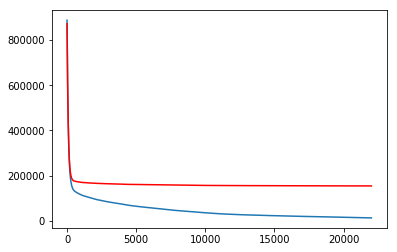

In [11]:
loss1 = model.evals_result_['training']['l1']
loss2 = model.evals_result_['valid_1']['l1']
plt.plot(loss1,label='training')
plt.plot(loss2,color='red',label='test')
plt.show()

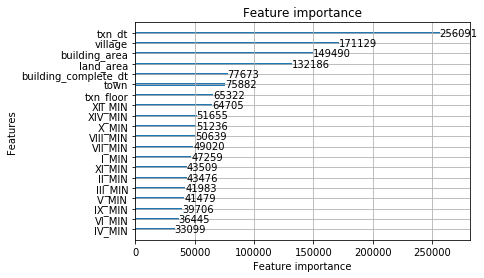

In [12]:
lgb.plot_importance(model, max_num_features=20)

In [18]:
max_depth=16
num_leaves=256
metric = 'l1'
model.booster_.save_model(f'models/lightgbm{max_depth}_{num_leaves}_{metric}.txt')
yhat = model.predict(X_test)

In [19]:
def score(yhat,y):
    z = 0
    z2 = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present <= 0.1):
            z += 1
        if(present > 0.2):
            z2 += 1
    print('(1-total/len(y)) = ',(1-total/len(y)))
    print(f'> 20 % : {z2/len(y)}')
    return z/len(y),z/len(y)*10000 + (1-total/len(y))
hit_rate,point = score(yhat*X_test['building_area'].values,y_test*X_test['building_area'].values)

(1-total/len(y)) =  0.8250151739875319
> 20 % : 0.22591666666666665


In [20]:
hit_rate

0.541

In [21]:
point

5410.825015173988

In [ ]:
test_data = pd.read_csv('data/test.csv')
test_x = test_data.iloc[:,1:]
predict_y = model.predict(test_x)

In [34]:
predict_y = test_x['building_area'].values*predict_y
test_data = pd.read_csv('data/submit_test.csv')

In [35]:
result_data= {'building_id': test_data['building_id'], 'total_price': predict_y}
result = pd.DataFrame(data=result_data)

In [36]:
result

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.117195e+07
1,BTshNOJyKHnT2YIT,4.095687e+06
2,dhdymr0lV8N5kZOT,1.049232e+07
3,VEwyGGMcD56w5BOc,6.277546e+06
4,wmUeMoJZfsqaSX9b,1.143096e+06
5,EtBjGAHmHCe9t7TZ,2.351523e+06
6,hPNH34vmaZtvBtqc,1.148518e+07
7,wXjeI38bYDMJJwZC,6.521007e+06
8,fxZSGX6aPAFKU8W4,1.502049e+06
9,ewr0Fx6ign87OwaV,4.564343e+06


In [2]:
from datetime import date
today = str(date.today())
result.to_csv(f'submits/{today}_lightgbm.csv',index = False)

NameError: name 'result' is not defined

In [3]:
df = pd.read_csv('data/train.csv')
df['avg_price'] = df['total_price']/df['building_area']
df['avg_parking_price'] = df['parking_price']/df['parking_area']

In [4]:
df.corr()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,avg_price,avg_parking_price
building_material,1.000000,-0.012731,-0.002216,0.363250,-0.272921,0.090499,0.458008,-0.193550,0.058634,0.253680,...,0.005728,-0.003895,-0.012676,NaN,0.038502,NaN,0.058962,0.032134,0.009739,-0.009135
city,-0.012731,1.000000,-0.001241,-0.058233,0.152503,-0.047762,-0.012564,0.091935,-0.024149,-0.007951,...,-0.234063,0.009210,-0.356419,NaN,-0.410657,NaN,0.018348,0.001849,-0.033148,0.156871
txn_dt,-0.002216,-0.001241,1.000000,-0.020022,0.002026,0.008766,-0.012505,-0.005462,0.020063,0.057697,...,0.011276,0.005745,0.009648,NaN,0.013094,NaN,-0.017822,0.000062,0.027842,-0.001116
total_floor,0.363250,-0.058233,-0.020022,1.000000,-0.661041,0.091811,0.474178,-0.527238,0.012415,0.044693,...,0.006678,0.010564,0.044092,NaN,0.105976,NaN,0.018908,0.044604,0.045042,-0.077123
building_type,-0.272921,0.152503,0.002026,-0.661041,1.000000,-0.065299,-0.064087,0.345933,-0.039372,-0.048123,...,-0.078232,-0.009574,-0.194788,NaN,-0.282546,NaN,0.060951,-0.008118,-0.081383,0.062585
building_use,0.090499,-0.047762,0.008766,0.091811,-0.065299,1.000000,0.094612,-0.039113,0.023070,0.062477,...,0.090221,0.002634,0.034521,NaN,0.067943,NaN,-0.053447,0.043713,0.036069,0.052696
building_complete_dt,0.458008,-0.012564,-0.012505,0.474178,-0.064087,0.094612,1.000000,-0.439157,0.025264,0.135892,...,-0.059839,-0.002609,-0.134695,NaN,-0.163715,NaN,0.209373,0.059482,-0.079413,-0.009098
parking_way,-0.193550,0.091935,-0.005462,-0.527238,0.345933,-0.039113,-0.439157,1.000000,-0.099754,-0.259239,...,0.016785,-0.006142,0.003658,NaN,-0.035403,NaN,-0.088957,-0.090435,-0.018693,0.171261
parking_area,0.058634,-0.024149,0.020063,0.012415,-0.039372,0.023070,0.025264,-0.099754,1.000000,0.110860,...,-0.005376,NaN,-0.016312,NaN,0.019454,NaN,0.046214,0.377045,0.070100,-0.079431
parking_price,0.253680,-0.007951,0.057697,0.044693,-0.048123,0.062477,0.135892,-0.259239,0.110860,1.000000,...,0.043027,NaN,0.120543,NaN,0.229069,NaN,-0.032613,0.458674,0.776035,0.326356


In [5]:
df.corr().sort_values(by=['avg_price'],ascending=False)

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,avg_price,avg_parking_price
avg_price,0.009739,-0.033148,0.027842,0.045042,-0.081383,0.036069,-0.079413,-0.018693,0.070100,0.776035,...,0.000037,-0.001562,0.056967,NaN,0.188819,NaN,-0.041674,0.386321,1.000000,0.450423
parking_price,0.253680,-0.007951,0.057697,0.044693,-0.048123,0.062477,0.135892,-0.259239,0.110860,1.000000,...,0.043027,NaN,0.120543,NaN,0.229069,NaN,-0.032613,0.458674,0.776035,0.326356
avg_parking_price,-0.009135,0.156871,-0.001116,-0.077123,0.062585,0.052696,-0.009098,0.171261,-0.079431,0.326356,...,0.017605,NaN,0.034943,NaN,0.131979,NaN,-0.109751,0.108896,0.450423,1.000000
XIII_5000,0.071946,-0.102198,0.021126,0.066788,-0.281286,0.104464,-0.288491,0.026798,0.045501,0.686239,...,0.148726,0.004699,0.353795,NaN,0.533227,NaN,-0.169982,0.161861,0.441153,0.401986
bachelor_rate,0.087437,0.145218,0.015106,0.037407,-0.188805,0.087504,-0.198977,0.004004,0.056768,0.633461,...,-0.050148,0.003452,0.000198,NaN,0.219452,NaN,-0.073408,0.168585,0.412978,0.385805
master_rate,0.082394,0.171192,0.013500,0.015191,-0.158382,0.086871,-0.195798,0.018322,0.055825,0.610375,...,-0.085268,0.003347,-0.061492,NaN,0.143685,NaN,-0.063246,0.168603,0.407559,0.374429
doc_Rate,0.071606,0.232003,0.015052,-0.010779,-0.115513,0.079665,-0.199133,0.039166,0.051031,0.590219,...,-0.111162,0.005055,-0.102184,NaN,0.093612,NaN,-0.066106,0.165599,0.396309,0.375257
VII_5000,0.054419,-0.013812,0.021847,0.092491,-0.263107,0.091054,-0.292306,0.041385,0.037777,0.568630,...,0.102693,0.011221,0.334888,NaN,0.582623,NaN,-0.216929,0.140251,0.396189,0.396709
V_5000,0.058766,-0.038531,0.021858,0.102220,-0.286858,0.092819,-0.291775,0.031450,0.036966,0.575056,...,0.147215,0.012303,0.419475,NaN,0.638509,NaN,-0.227677,0.136286,0.391740,0.390297
jobschool_rate,0.110118,-0.020746,0.011714,0.139612,-0.326218,0.081349,-0.195549,-0.056987,0.058511,0.626380,...,0.051777,0.001371,0.152198,NaN,0.387673,NaN,-0.082246,0.150532,0.389562,0.374474


In [179]:
table = df['parking_price'].isna()

In [64]:
data = np.array([])
y = np.array([])
for index,t in enumerate(table):
    if not t:
        temp1 = df['parking_price'].iloc[index]
        temp2 = df['avg_price'].iloc[index]
        data = np.append(data,temp1)
        y = np.append(y,temp2)
df2 = pd.DataFrame(data={
    'parking_price':data,
    'avg_price':y
})

In [65]:
df2.corr()

,avg_price,parking_price
avg_price,1.000000,0.754495
parking_price,0.754495,1.000000


In [55]:
print(data)

[]


In [66]:
from sklearn.linear_model import LinearRegression

In [180]:
table = df['parking_price'].isna().values
data = np.array([])
y = np.array([])
for index,t in enumerate(table):
    if not t:
        temp1 = df['parking_price'].iloc[index]
        temp2 = df['avg_price'].iloc[index]
        data = np.append(data,temp1)
        y = np.append(y,temp2)
df2 = pd.DataFrame(data={
    'parking_price':data,
    'avg_price':y
})

In [181]:
reg = LinearRegression().fit(y.reshape(-1,1), data.reshape(-1,1))

In [182]:
pre = reg.predict(df['avg_price'].values.reshape(-1,1))

In [183]:
print(pre[0][0])

27658.563202222464


In [184]:
table = pd.isnull(df['parking_price'])
prediction = pre.reshape(-1,)
print(len(prediction))

60000


In [185]:
col = np.array([])
col2 = df['parking_price'].values
for index,t in enumerate(table):
    if t:
        temp = prediction[index]
        col = np.append(col,temp)
    else:
        col = np.append(col,col2[index])

In [186]:
df['parking_price'] = col

In [109]:
df.corr().sor

0         27658.563202
1         40867.512899
2         59498.725623
3         81138.889762
4         27099.471180
5         25986.884178
6         61488.568950
7          6721.823057
8         28802.603173
9         61488.568950
10        36527.270498
11        36786.923635
12        36291.189856
13        49910.207607
14        46873.115176
15        33424.427681
16        43410.257497
17        34548.428853
18        48091.487209
19        44611.354219
20        67830.664907
21        51470.634262
22        34918.168255
23        37782.192739
24        34085.016731
25        49461.515554
26        90981.961822
27        30006.002827
28        29097.588441
29        55363.090169
             ...      
59970     28651.039388
59971     27334.841675
59972     19290.953735
59973     47301.176484
59974     79001.793802
59975     27968.026679
59976     48123.582411
59977     46888.137527
59978     32955.015879
59979     35241.189353
59980     45210.543894
59981     47880.112352
59982     3

In [189]:
floor_table = df.groupby('txn_floor').mean()['avg_price'].values
print(floor_table)

[1685963.18229431 1349536.32765118 1320726.22194503 1297240.88435969
 1271003.35448145 1338363.88637557 1378635.31990427 1245507.63021452
 1378044.28948709 1323499.11260538 1358526.74139964 1267821.33862403
 1310386.3406763  1147929.44006086 1145224.51495315 1093528.81875352
 1293776.49272904 1322778.7919978  1354605.55928921 1277377.136509
 1282949.83169887 1176741.13182021 1505697.22305046 1459342.13033516
 1874991.51531772 1179627.93708831 2100743.33303832 1371951.08786529]


In [190]:
table = df['txn_floor'].isna().values
data = np.array([])
y = np.array([])
for index,t in enumerate(table):
    if not t:
        floor = df['txn_floor'].iloc[index] - 1
        temp1 = floor_table[int(floor)]
        temp2 = df['avg_price'].iloc[index]
        data = np.append(data,temp1)
        y = np.append(y,temp2)
df2 = pd.DataFrame(data={
    'txn_floor':data,
    'avg_price':y
})

reg = LinearRegression().fit(y.reshape(-1,1), data.reshape(-1,1))

In [191]:
pre = reg.predict(df['avg_price'].values.reshape(-1,1))

In [192]:
table = pd.isnull(df['txn_floor'])
prediction = pre.reshape(-1,)
print(prediction)

[1346096.26847711 1351839.88774152 1359941.25800787 ... 1357424.28248486
 1363193.53091203 1358804.14974916]


In [193]:
col = np.array([])
col2 = df['txn_floor'].values
for index,t in enumerate(table):
    if t:
        temp = prediction[index]
        col = np.append(col,temp)
    else:
        floor = col2[index] - 1
        temp2 = floor_table[int(floor)]
        col = np.append(col,temp2)
print(col)

[1320726.22194503 1271003.35448145 1685963.18229431 ... 1338363.88637557
 1320726.22194503 1297240.88435969]


In [194]:
df['txn_floor'] = col

In [196]:
df.corr().sort_values(by=['txn_floor'])['txn_floor']

total_floor             -0.205435
building_complete_dt    -0.149932
V_index_50              -0.079254
V_50                    -0.075604
N_50                    -0.074178
highschool_rate         -0.071810
VIII_50                 -0.068714
VIII_index_50           -0.067161
VII_10                  -0.066821
VIII_10                 -0.064542
III_index_50            -0.061052
III_50                  -0.060932
V_100                   -0.058560
VII_50                  -0.057170
VIII_100                -0.054090
XI_50                   -0.052573
XI_index_50             -0.052176
IX_50                   -0.052161
V_10                    -0.051443
building_material       -0.049959
IX_index_50             -0.049251
elementary_rate         -0.048093
XII_10                  -0.047047
III_100                 -0.045823
VII_index_50            -0.045558
IX_100                  -0.045021
village_income_median   -0.044919
III_10                  -0.044394
junior_rate             -0.042996
IX_10         

In [132]:
#df = df.drop(['parking_area','avg_parking_price','total_price'],axis=1)
df = df.drop(['avg_parking_price','total_price'],axis=1)

In [134]:
df3 = df.drop(['building_id'],axis=1)

In [136]:
df3.to_csv('data/clean_data.csv')

In [145]:
train_y = df3['avg_price']
train_x = df3.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
entity_features_columns = ['building_material','city','town','village','building_type','building_use','parking_way']
def score(y,yhat):
    z = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present > 0.1):
            z += 1
    print((1-total/len(y)))
    return z,z/len(y)*10000 + (1-total/len(y))
def custom_loss(y_true, y_pred):
    z , point = score(y_true,y_pred)
    return 'custom_loss',z, False
"""
def custom_loss(y_true, y_pred):
    loss = np.sum(np.abs(y_true-y_pred)/y_true)
    return 'custom_loss',loss, False
"""
def train_LGBM(train, t_target, valid, v_target):
      
    rf = LGBMRegressor(learning_rate=0.01,objective='regression', n_estimators=100000,
                       max_depth=8, num_leaves=64,
                       feature_fraction=0.9, bagging_freq=1,metric='rmse')

    rf.fit(train, t_target, # should we drop the features that are not correlate to our target?
           eval_set=[(train, t_target), (valid, v_target)],
           early_stopping_rounds=100, verbose=10,
           eval_metric='l1',
           categorical_feature=entity_features_columns
           )
    print("Finished.")
    return rf
model = train_LGBM(X_train, y_train, X_test, y_test)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['building_material', 'building_type', 'building_use', 'city', 'parking_way', 'town', 'village']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[10]	training's l1: 812755	valid_1's l1: 798000
[20]	training's l1: 738165	valid_1's l1: 724470
[30]	training's l1: 671279	valid_1's l1: 658388
[40]	training's l1: 611089	valid_1's l1: 598475
[50]	training's l1: 557231	valid_1's l1: 545269
[60]	training's l1: 508721	valid_1's l1: 497221
[70]	training's l1: 465046	valid_1's l1: 454104
[80]	training's l1: 426063	valid_1's l1: 415441
[90]	training's l1: 391321	valid_1's l1: 381099
[100]	training's l1: 360545	valid_1's l1: 350655
[110]	training's l1: 332280	valid_1's l1: 322664
[120]	training's l1: 306719	valid_1's l1: 297746
[130]	training's l1: 283554	valid_1's l1: 275221
[140]	training's l1: 262894	valid_1's l1: 255158
[150]	training's l1: 244098	valid_1's l1: 236871
[160]	training's l1: 227377	valid_1's l1: 220732
[170]	training's l1: 212703	valid_1's l1: 206637
[180]	training's l1: 199174	valid_1's l1: 193620
[190]	training's l1: 187085	valid_1's l1: 182035
[200]	training'

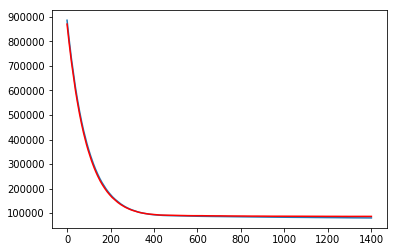

In [146]:
loss1 = model.evals_result_['training']['l1']
loss2 = model.evals_result_['valid_1']['l1']
plt.plot(loss1,label='training')
plt.plot(loss2,color='red',label='test')
plt.show()

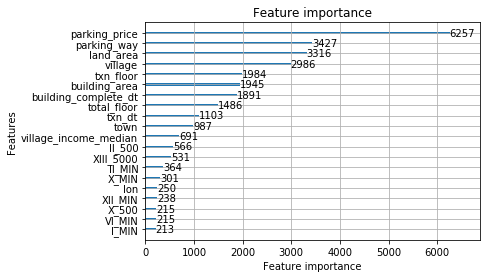

In [147]:
lgb.plot_importance(model, max_num_features=20)

In [151]:
yhat = model.predict(X_test)
def score(yhat,y):
    z = 0
    z2 = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present <= 0.1):
            z += 1
        if(present > 0.2):
            z2 += 1
    print('(1-total/len(y)) = ',(1-total/len(y)))
    print(f'> 20 % : {z2/len(y)}')
    return z/len(y),z/len(y)*10000 + (1-total/len(y))
hit_rate,point = score(yhat*X_test['building_area'].values,y_test*X_test['building_area'].values)

(1-total/len(y)) =  0.90339563613538
> 20 % : 0.10733333333333334


In [152]:
hit_rate

0.7823333333333333

In [153]:
point

7824.2367289694685

In [154]:
model.booster_.save_model(f'models/lightgbm_8_64_l1_clean_data.txt')

In [155]:
test_data = pd.read_csv('data/test.csv')
test_x = test_data.iloc[:,1:]
predict_y = model.predict(test_x)
predict_y = test_x['building_area'].values*predict_y
test_data = pd.read_csv('data/submit_test.csv')
result_data= {'building_id': test_data['building_id'], 'total_price': predict_y}
result = pd.DataFrame(data=result_data)

ValueError: Number of features of the model must match the input. Model n_features_ is 232 and input n_features is 233 

In [160]:
df = pd.read_csv('data/test.csv')
df['avg_price'] = df['total_price']/df['building_area']
df['avg_parking_price'] = df['parking_price']/df['parking_area']
table = df['parking_price'].isna().values
data = np.array([])
y = np.array([])
for index,t in enumerate(table):
    if not t:
        temp1 = df['parking_price'].iloc[index]
        temp2 = df['avg_price'].iloc[index]
        data = np.append(data,temp1)
        y = np.append(y,temp2)
df2 = pd.DataFrame(data={
    'parking_price':data,
    'avg_price':y
})
parking_price_reg = LinearRegression().fit(y.reshape(-1,1), data.reshape(-1,1))
pre = parking_price_reg.predict(df['avg_price'].values.reshape(-1,1))
table = pd.isnull(df['parking_price'])
prediction = pre.reshape(-1,)
print(len(prediction))
col = np.array([])
col2 = df['parking_price'].values
for index,t in enumerate(table):
    if t:
        temp = prediction[index]
        col = np.append(col,temp)
    else:
        col = np.append(col,col2[index])
df['parking_price'] = col


floor_table = df.groupby('txn_floor').mean()['avg_price'].values
print(floor_table)
table = df['txn_floor'].isna().values
data = np.array([])
y = np.array([])
for index,t in enumerate(table):
    if not t:
        floor = df['txn_floor'].iloc[index] - 1
        temp1 = floor_table[int(floor)]
        temp2 = df['avg_price'].iloc[index]
        data = np.append(data,temp1)
        y = np.append(y,temp2)
df2 = pd.DataFrame(data={
    'txn_floor':data,
    'avg_price':y
})

txn_floor_reg = LinearRegression().fit(y.reshape(-1,1), data.reshape(-1,1))
pre = txn_floor_reg.predict(df['avg_price'].values.reshape(-1,1))

table = pd.isnull(df['txn_floor'])
prediction = pre.reshape(-1,)
print(prediction)

col = np.array([])
col2 = df['txn_floor'].values
for index,t in enumerate(table):
    if t:
        temp = prediction[index]
        col = np.append(col,temp)
    else:
        floor = col2[index] - 1
        temp2 = floor_table[int(floor)]
        col = np.append(col,temp2)
print(col)

df['txn_floor'] = col

10000
[1644514.6304937  1329012.26386645 1264819.67530656 1255029.5057482
 1250668.8002794  1370918.49709858 1470419.26773024 1262693.10993709
 1530264.86527439 1441225.88473403 1369920.13427963 1334028.59666885
 1200445.98223289 1225200.7250596  1006026.80260167 1224516.13288924
 1275988.22184359 1284314.57818592 1309251.58351691  902329.95635671
 1142483.2363017  1600692.14569684 2487104.54833049 2338115.71492766
 1112624.22985104  934415.50877445 1476735.26136068]
[1371598.69036906 1342069.87130772 1345650.08244221 ... 1337793.56479888
 1345266.50424492 1339550.35046107]
[1371598.69036906 1329012.26386645 1345650.08244221 ... 1337793.56479888
 1329012.26386645 1370918.49709858]


In [161]:
df

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,avg_price,avg_parking_price
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,129,1,3991,1,8409,1,105.462231,1.117195e+07,3.268397e+06,NaN
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,67,1,1950,1,10725,1,100.819809,4.095687e+06,5.301019e+05,NaN
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,35,1,3707,1,19459,1,259.800543,1.049232e+07,8.621054e+05,NaN
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,144,1,6487,1,29400,1,22.941906,6.277546e+06,2.787226e+06,NaN
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,76,1,1346,1,3280,1,181.213095,1.143096e+06,1.966114e+05,NaN
5,EtBjGAHmHCe9t7TZ,8,12,18632,4,4,2,15464,2,NaN,...,88,1,2144,1,5477,1,206.701060,2.351523e+06,2.023030e+05,NaN
6,hPNH34vmaZtvBtqc,8,7,19144,14,0,2,16590,0,NaN,...,380,1,9419,1,23499,1,77.249329,1.148518e+07,1.355171e+06,NaN
7,wXjeI38bYDMJJwZC,8,13,19452,5,1,2,7124,2,NaN,...,273,1,2729,1,12880,1,155.031982,6.521007e+06,1.702226e+06,NaN
8,fxZSGX6aPAFKU8W4,1,17,19045,2,4,2,12634,2,NaN,...,27,1,459,1,1693,1,81.407991,1.502049e+06,1.460652e+05,NaN
9,ewr0Fx6ign87OwaV,8,7,19220,13,2,10,17351,2,NaN,...,127,1,5742,1,23399,1,16.357214,4.564343e+06,1.871844e+06,NaN


In [166]:
df_drop = df.drop(['building_id','parking_area','avg_parking_price','total_price','avg_price'],axis=1)

In [167]:
df_drop

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_price,txn_floor,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,1,13,18634,2,4,2,1857,2,92737.195111,1.371599e+06,...,7,21,1,129,1,3991,1,8409,1,105.462231
1,8,7,20199,10,3,2,16011,2,34005.565094,1.329012e+06,...,18,44,1,67,1,1950,1,10725,1,100.819809
2,8,12,19769,4,4,10,18294,2,41126.460627,1.345650e+06,...,0,3,1,35,1,3707,1,19459,1,259.800543
3,10,7,20479,19,2,0,17837,2,82416.920867,1.224516e+06,...,16,60,1,144,1,6487,1,29400,1,22.941906
4,8,3,18164,13,0,2,13272,2,26852.778052,1.264820e+06,...,4,18,1,76,1,1346,1,3280,1,181.213095
5,8,12,18632,4,4,2,15464,2,26974.852919,1.338535e+06,...,7,19,1,88,1,2144,1,5477,1,206.701060
6,8,7,19144,14,0,2,16590,0,61488.568950,1.369920e+06,...,17,64,1,380,1,9419,1,23499,1,77.249329
7,8,13,19452,5,1,2,7124,2,59145.586848,1.264820e+06,...,3,22,1,273,1,2729,1,12880,1,155.031982
8,1,17,19045,2,4,2,12634,2,25768.650275,1.337929e+06,...,2,11,1,27,1,459,1,1693,1,81.407991
9,8,7,19220,13,2,10,17351,2,62783.579955,1.441226e+06,...,4,17,1,127,1,5742,1,23399,1,16.357214


In [169]:
predict_y = model.predict(df_drop)
predict_y = df_drop['building_area'].values*predict_y
print(predict_y)
test_data = pd.read_csv('data/submit_test.csv')
result_data= {'building_id': test_data['building_id'], 'total_price': predict_y}
result = pd.DataFrame(data=result_data)

[11259791.06090015  3854512.37658995  9525246.41913757 ...
  1101509.58338761  3021955.63796721  3110433.84779482]


In [170]:
result

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.125979e+07
1,BTshNOJyKHnT2YIT,3.854512e+06
2,dhdymr0lV8N5kZOT,9.525246e+06
3,VEwyGGMcD56w5BOc,6.266061e+06
4,wmUeMoJZfsqaSX9b,8.132983e+05
5,EtBjGAHmHCe9t7TZ,2.108964e+06
6,hPNH34vmaZtvBtqc,1.022949e+07
7,wXjeI38bYDMJJwZC,6.537249e+06
8,fxZSGX6aPAFKU8W4,1.400515e+06
9,ewr0Fx6ign87OwaV,4.747834e+06


In [171]:
result.to_csv('submits/clean_data_lightgbm.csv',index=False)